# **Cleaned Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install sentencepiece
!pip install transformers
!pip install timm

In [3]:
import gc
import pandas as pd
import numpy as np
import os
import torch
import glob
import pathlib
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
import math
warnings.filterwarnings('ignore')
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')

root_data = '/content/drive/MyDrive/webNLG/PROJECT/Data/'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
if torch.cuda.is_available():
   dev = torch.device("cuda:0")
   print("Running on the GPU")
else:
   dev = torch.device("cpu")
   print("Running on the CPU")

Running on the GPU


##**Loading Datasets**

In [5]:
root = '/content/drive/MyDrive/webNLG/PROJECT/modified/'

In [6]:
processed_train_data = pd.read_csv(root + 'clean_train.csv') #final processed dataset with all unwanted characters removed.
processed_dev_data = pd.read_csv(root + 'dev/new_dev.csv')

In [7]:
processed_train_data = processed_train_data.iloc[:4500,:]
processed_train_data = processed_train_data.sample(frac=1)
batch_size = 8
numOfBatches = math.floor(len(processed_train_data)/batch_size)

In [8]:
%%capture
Tokenizer = T5Tokenizer.from_pretrained('t5-base')
Model = T5ForConditionalGeneration.from_pretrained('t5-base',
                                             return_dict=True)
Model.to(dev)

###**Loading the Optimiser**

In [9]:
Optimizer = Adafactor(
    Model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [10]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        
            {value}
        
    """.format(loss=loss,value=value, max=max))

In [11]:
num_of_epochs=10

#**Train the Model**

In [12]:
#Sets the module in training mode
Model.train()

loss_per_10steps=[]
for epoch in range(1, num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  runningLoss = 0

  out = display(progress(1, numOfBatches+1), display_id=True)
  for i in range(numOfBatches):

    inputbatch = []
    labelbatch = []
    new_data= processed_train_data[i*batch_size:i*batch_size+batch_size]
    for index,row in new_data.iterrows():
      input = row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'    
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch = Tokenizer.batch_encode_plus(inputbatch,truncation=True,padding=True,return_tensors ='pt')["input_ids"]
    labelbatch = Tokenizer.batch_encode_plus(labelbatch,truncation=True,padding=True,return_tensors ="pt") ["input_ids"]
    inputbatch = inputbatch.to(dev)
    labelbatch = labelbatch.to(dev)

    # clear out the gradients of all Variables 
    Optimizer.zero_grad()

    # Forward propogation
    outputs = Model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num = loss.item()
    logits = outputs.logits
    runningLoss += loss_num
    if i%10 == 0:      
      loss_per_10steps.append(loss_num)
    out.update(progress(loss_num,i, numOfBatches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    Optimizer.step()

  running_loss = runningLoss/int(numOfBatches)
  print('Epoch: {} , Running loss: {}'.format(epoch,runningLoss))
  

Running epoch: 1


Epoch: 1 , Running loss: 127.33747351169586
Running epoch: 2


Epoch: 2 , Running loss: 75.92489540576935
Running epoch: 3


Epoch: 3 , Running loss: 61.35766725242138
Running epoch: 4


Epoch: 4 , Running loss: 52.957039304077625
Running epoch: 5


Epoch: 5 , Running loss: 45.37749973684549
Running epoch: 6


Epoch: 6 , Running loss: 40.03943581879139
Running epoch: 7


Epoch: 7 , Running loss: 35.147921688854694
Running epoch: 8


Epoch: 8 , Running loss: 31.151172809302807
Running epoch: 9


Epoch: 9 , Running loss: 28.618253149092197
Running epoch: 10


Epoch: 10 , Running loss: 26.593225669115782


##**Plotting for Loss**

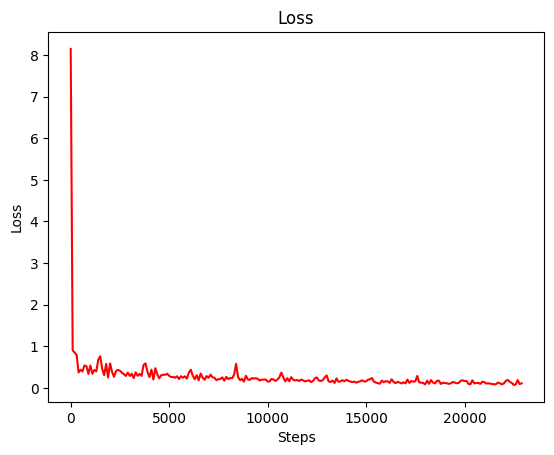

In [13]:
# Plotting the loss
steps = [i*100 for i in range(len(loss_per_10steps))] 
plt.plot(steps, loss_per_10steps, color='red')  # Set the color to red
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

#**Testing the Model**

In [14]:
Model.eval()
input_ids = Tokenizer.encode("Russia | leader | Putin", return_tensors="pt")  # Batch size 1
input_ids = input_ids.to(dev)
outputs = Model.generate(input_ids)
Tokenizer.decode(outputs[0], skip_special_tokens=True)     

'The leader of Russia is Putin., Putin is the leader of Russia., The'

In [15]:
def make_prediction(model, text):

   Model.eval()
   input_ids = Tokenizer.encode(text, return_tensors="pt").to(dev)  # Batch size 1
   s = time.time()
   outputs = Model.generate(input_ids)
   gen_text = Tokenizer.decode(outputs[0], skip_special_tokens=True)
   elapsed = time.time() - s
   print('Generated in {} seconds'.format(str(elapsed)[:4]))
   return gen_text

make_prediction(Model, 'Russia | leader | Putin')

Generated in 0.56 seconds


'The leader of Russia is Putin., Putin is the leader of Russia., The'

#**Evaluating the Model**

In [16]:
%%capture
#geting the inputs (input_text) from the dataset
processed_dev_data_inputs = [ x.replace('[','').replace(']','') for x in processed_dev_data['input_text'].values.tolist() ]

#feeding the input into the model and getting the predictions
processed_dev_data_pred = [ make_prediction(Model, x) for x in processed_dev_data_inputs ]

#loading the reference values from the target_text column
processed_dev_data_ref = [ x.replace('[','').replace(']','') for x in processed_dev_data['target_text'].values.tolist() ]

In [17]:
import os
import locale
locale.getpreferredencoding = lambda: "UTF-8"

file_path_ref = 'processed_dev_reference.txt'
file_path_hypo = 'processed_dev_hypothesis.txt'

# Create or overwrite the files
with open(file_path_ref, 'w', encoding='utf-8') as f:
    for row in processed_dev_data_ref:
        f.write(row + '\n')

with open(file_path_hypo, 'w', encoding='utf-8') as f:
    for row in processed_dev_data_pred:
        f.write(row + '\n')

In [ ]:
from google.colab import files

uploaded = files.upload()

In [18]:
!pip install meteor pyter3 bert_score razdel tabulate sacrebleu -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 9.5 MB/s eta 0:00:00


In [19]:
processed_data_eval = !python {root_data}eval.py -hyp processed_dev_hypothesis.txt -ref processed_dev_reference.txt -nr 1 -m bleu,meteor,bert,chrf++,ter -lng en

In [20]:
processed_data_eval_df = processed_data_eval[-3:]
processed_data_eval_df
#result = pd.DataFrame(processed_data_eval_df)
#result.to_csv(root + 'result.csv', index=False)

['   BLEU    METEOR    chrF++    TER    BERT-SCORE P    BERT-SCORE R    BERT-SCORE F1',
 '-------  --------  --------  -----  --------------  --------------  ---------------',
 '9.33756        -1      0.34   0.76             0.9            0.88             0.89']